In [1]:
# sources
# https://stackoverflow.com/questions/11303225/how-to-remove-multiple-indexes-from-a-list-at-the-same-time



In [2]:
# imports

import pandas as pd
import numpy as np
import os
import random
import torch
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler
from transformers import BertTokenizer, BertConfig
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import transformers
from transformers import BertForTokenClassification, AdamW, BertTokenizerFast
from transformers import get_linear_schedule_with_warmup
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, confusion_matrix



In [3]:
class dataset(Dataset):
    def __init__(self, abstracts, labels, tokenizer, max_len):
        self.len = len(abstracts)
        self.abstracts = abstracts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __getitem__(self, index):
        # step 1: get the sentence and word labels 
        sentence = self.abstracts[index]
        word_labels = self.labels[index]

        # step 2: use tokenizer to encode sentence (includes padding/truncation up to max length)
        # BertTokenizerFast provides a handy "return_offsets_mapping" functionality for individual tokens
        encoding = self.tokenizer(sentence,
                             is_split_into_words=True,
                             return_offsets_mapping=True, 
                             padding='max_length', 
                             truncation=True, 
                             max_length=self.max_len)

        # step 3: create token labels only for first word pieces of each tokenized word
        labels = [labels_to_ids[label] for label in word_labels] 
        # code based on https://huggingface.co/transformers/custom_datasets.html#tok-ner
        # create an empty array of -100 of length max_length
        encoded_labels = np.ones(len(encoding["offset_mapping"]), dtype=int) * -100

        # set only labels whose first offset position is 0 and the second is not 0
        i = 0
        for idx, mapping in enumerate(encoding["offset_mapping"]):
            if mapping[0] == 0 and mapping[1] != 0:
                # overwrite label
                encoded_labels[idx] = labels[i]
                i += 1

        # step 4: turn everything into PyTorch tensors
        item = {key: torch.as_tensor(val) for key, val in encoding.items()}
        item['labels'] = torch.as_tensor(encoded_labels)

        return item

    def __len__(self):
        return self.len

In [4]:
def process_data(tokenizer, abstracts_tr, labels_tr, abstracts_test, labels_test, MAX_LEN, tag2idx, bs, random_seed=42):

    
    training_set = dataset(abstracts_tr, labels_tr, tokenizer, MAX_LEN)
    testing_set = dataset(abstracts_test, labels_test, tokenizer, MAX_LEN)
    
    
    train_params = {'batch_size': bs,
                    'shuffle': True,
                    'num_workers': 0
                    }

    test_params = {'batch_size': bs,
                    'shuffle': True,
                    'num_workers': 0
                    }

    training_loader = DataLoader(training_set, **train_params)
    testing_loader = DataLoader(testing_set, **test_params)
    
    print(len(tokenizer))
    
    return training_loader, testing_loader


In [66]:
def train(train_dataloader, valid_dataloader, epochs=5, dropout=0.3):

    # initialize model
#     model = BertForTokenClassification.from_pretrained(
#         "emilyalsentzer/Bio_ClinicalBERT",  # bert-base-cased
#         num_labels=len(labels_to_ids),
#     )
    
    model = BertForTokenClassification.from_pretrained('bert-base-uncased', num_labels=len(labels_to_ids))

#     model.cuda()
    model.to(device)
    
    print(model.config.vocab_size)


    FULL_FINETUNING = True
    if FULL_FINETUNING:
        param_optimizer = list(model.named_parameters())
        no_decay = ['bias', 'gamma', 'beta']
        optimizer_grouped_parameters = [
            {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.01},
            {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
             'weight_decay_rate': 0.0}
        ]
    else:
        param_optimizer = list(model.classifier.named_parameters())
        optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

    optimizer = AdamW(
        optimizer_grouped_parameters,
        lr=3e-5,
        eps=1e-8
    )

    max_grad_norm = 1.0

    # Total number of training steps is number of batches * number of epochs.
    total_steps = len(train_dataloader) * epochs

    # Create the learning rate scheduler.
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )   


    ## Store the average loss after each epoch so we can plot them.
    loss_values, validation_loss_values = [], []

    accuracy_values, F1_values, precision_values, recall_values = [], [], [], []

    done = False
    for e in trange(epochs, desc="Epoch"):
        # ========================================
        #               Training
        # ========================================
        # Perform one full pass over the training set.

        # Put the model into training mode.
        model.train()
        # Reset the total loss for this epoch.
        total_loss = 0

        # Training loop
        for step, batch in enumerate(train_dataloader):
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            # Always clear any previously calculated gradients before performing a backward pass.
            model.zero_grad()
            # forward pass
            # This will return the loss (rather than the model output)
            # because we have provided the `labels`.
            outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
            # get the loss
            loss = outputs[0]
            # Perform a backward pass to calculate the gradients.
            loss.backward()
            # track train loss
            total_loss += loss.item()
            # Clip the norm of the gradient
            # This is to help prevent the "exploding gradients" problem.
            torch.nn.utils.clip_grad_norm_(parameters=model.parameters(), max_norm=max_grad_norm)
            # update parameters
            optimizer.step()
            # Update the learning rate.
            scheduler.step()

        # Calculate the average loss over the training data.
        avg_train_loss = total_loss / len(train_dataloader)
        print("Average train loss: {}".format(avg_train_loss))

        # Store the loss value for plotting the learning curve.
        loss_values.append(avg_train_loss)


        # ========================================
        #               Validation
        # ========================================
        # After the completion of each training epoch, measure our performance on
        # our validation set.

        # Put the model into evaluation mode
        model.eval()
        # Reset the validation loss for this epoch.
        eval_loss, eval_accuracy = 0, 0
        nb_eval_steps, nb_eval_examples = 0, 0
        predictions , true_labels = [], []
        for batch in valid_dataloader:
            
            ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            labels = batch['labels'].to(device, dtype = torch.long)
            
            # Telling the model not to compute or store gradients,
            # saving memory and speeding up validation
            with torch.no_grad():
                # Forward pass, calculate logit predictions.
                # This will return the logits rather than the loss because we have not provided labels.
                outputs = model(input_ids=ids, attention_mask=mask, labels=labels)
            
            eval_loss += outputs[0].mean().item()
            
            # compute evaluation accuracy
            flattened_targets = labels.view(-1) # shape (batch_size * seq_len,)
            active_logits = outputs[1].view(-1, model.num_labels) # shape (batch_size * seq_len, num_labels)
            flattened_predictions = torch.argmax(active_logits, axis=1) # shape (batch_size * seq_len,)
            
            # only compute accuracy at active labels
            active_accuracy = labels.view(-1) != -100 # shape (batch_size, seq_len)
        
            labels = torch.masked_select(flattened_targets, active_accuracy)
            curr_predictions = torch.masked_select(flattened_predictions, active_accuracy)
            
            true_labels.extend(labels)
            predictions.extend(curr_predictions)
            
            abs_ids = ids.tolist()
            # print out an input abstract, abstract's gold labels, and BERT's predictions
            if e == 0 and not done and len(abs_ids[0]) > 3 and ('evaluation' in tokenizer.decode(abs_ids[0][1])) and ('of' in tokenizer.decode(abs_ids[0][2])) and ('three' in tokenizer.decode(abs_ids[0][3])):
                [print(tokenizer.decode(example), '\n') for example in ids.tolist()[0]]
                [print(flattened_targets.tolist())]
                print('********************')
                [print(flattened_predictions.tolist())]
                done = True
        
        valid_tags = [ids_to_labels[id.item()] for id in true_labels]
        pred_tags = [ids_to_labels[id.item()] for id in predictions]

        eval_loss = eval_loss / len(valid_dataloader)
        validation_loss_values.append(eval_loss)
        print("Validation loss: {}".format(eval_loss))

        accuracy = accuracy_score(valid_tags, pred_tags)
        print("Validation Accuracy: {}".format(accuracy))
        accuracy_values.append(accuracy)

        precision = precision_score(valid_tags, pred_tags, labels=['0', '1'], average='macro')
        print("Validation Precision-Score: {}".format(precision))
        precision_values.append(precision)

        recall = recall_score(valid_tags, pred_tags, labels=['0', '1'], average='macro')
        print("Validation Recall-Score: {}".format(recall))
        recall_values.append(recall)

        F1 = f1_score(valid_tags, pred_tags, labels=['0', '1'], average='macro')
        print("Validation F1-Score: {}".format(F1))
        F1_values.append(F1)
        print()


    # plotting the metrics

    # Use plot styling from seaborn.
    sns.set(style='darkgrid')

    # Increase the plot size and font size.
    sns.set(font_scale=1.5)
    plt.rcParams["figure.figsize"] = (12, 6)

    # Plot the learning curve.
    plt.plot(loss_values, 'b-o', label="training loss")
    plt.plot(validation_loss_values, 'r-o', label="validation loss")
    plt.plot(accuracy_values, 'g-o', label="accuracy")
    plt.plot(precision_values, 'c-o', label="precision")
    plt.plot(recall_values, 'm-o', label="recall")
    plt.plot(F1_values, 'y-o', label="F1")

    # Label the plot.
    plt.title("Learning curve")
    plt.xlabel("Epoch")
    plt.ylabel("Performance")
    plt.legend()

    plt.show()


    return accuracy, precision, recall, F1



30522


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForTokenClassification: ['cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-u

30522


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Average train loss: 0.19271833090756035
[CLS] 

evaluation 

of 

three 

dos 

##age 

- 

prediction 

methods 

for 

initial 

in 

- 

hospital 

stabilization 

of 

war 

##far 

##in 

therapy 

. 

three 

dos 

##age 

- 

prediction 

methods 

for 

initial 

in 

- 

hospital 

stabilization 

of 

war 

##far 

##in 

therapy 

were 

evaluated 

. 

adult 

in 

##patient 

##s 

who 

had 

received 

war 

##far 

##in 

sodium 

10 

mg 

daily 

for 

less 

than 

three 

days 

were 

eligible 

for 

the 

study 

. 

after 

receiving 

their 

third 

war 

##far 

##in 

dose 

, 

patients 

were 

randomly 

assigned 

to 

have 

their 

war 

##far 

##in 

dos 

##ages 

adjusted 

using 

one 

of 

three 

dos 

##age 

- 

prediction 

methods 

: 

by 

analog 

computer 

( 

n 

= 

31 

) 

, 

linear 

regression 

( 

n 

= 

22 

) 

, 

or 

em 

##pi 

##ric 

dos 

##ing 

by 

the 

physician 

( 

n 

= 

34 

) 

. 

a 

pro 

##th 

##rom 

Epoch:  20%|██        | 1/5 [01:03<04:15, 63.98s/it]

Validation F1-Score: 0.79627223603792

Average train loss: 0.12601887726928968
Validation loss: 0.19468897753158362
Validation Accuracy: 0.9404186795491143
Validation Precision-Score: 0.8465576162802293
Validation Recall-Score: 0.7624252316271343


Epoch:  40%|████      | 2/5 [02:07<03:12, 64.00s/it]

Validation F1-Score: 0.7971018207674125

Average train loss: 0.08340449897656262
Validation loss: 0.24339037841399028
Validation Accuracy: 0.9375
Validation Precision-Score: 0.8192584645240923
Validation Recall-Score: 0.7898838379871915


Epoch:  60%|██████    | 3/5 [03:12<02:08, 64.01s/it]

Validation F1-Score: 0.8036447947275656

Average train loss: 0.05241888673750957
Validation loss: 0.2927236550816106
Validation Accuracy: 0.9389090177133655
Validation Precision-Score: 0.8296079956712193
Validation Recall-Score: 0.7796573839908687


Epoch:  80%|████████  | 4/5 [04:17<01:04, 64.78s/it]

Validation F1-Score: 0.8019842697851916

Average train loss: 0.034461450939869756
Validation loss: 0.3068838659503746
Validation Accuracy: 0.9384393451422437
Validation Precision-Score: 0.822244890495695
Validation Recall-Score: 0.7930283856736519


Epoch: 100%|██████████| 5/5 [05:22<00:00, 64.47s/it]

Validation F1-Score: 0.8067304573900053



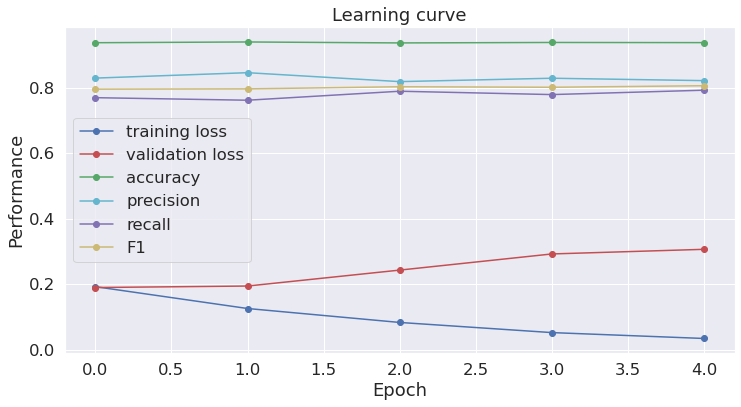

In [67]:
# main program

# reading in dataset which contains all training and test tokens, and info for every token.
df_train = pd.read_pickle('df_train.pickle')
df_test = pd.read_pickle('df_test.pickle')


# groups tokens into their corresponding abstracts. groups labels into their corresponding abstracts.
def abstract_labels(df_orig):
    abstracts = []
    labels = []
    df_abs_groups = df_orig.groupby('PMID')
    for name, group in df_abs_groups: # no order
        group_labs = group.gold.tolist()
        s = group.head(1).abstract.tolist()[0]
        
        # remove None type values from label and abstracts. Snorkel does the same.
        remove_indices = [i for i, v in enumerate(group_labs) if v == None]
        group_labs = [i for j, i in enumerate(group_labs) if j not in remove_indices]
        s = [i for j, i in enumerate(s) if j not in remove_indices]
        
        abstracts.append(s)
        labels.append(group_labs)
    
    return abstracts, labels

# two corresponding lists of abstracts and labels for each abtract
abstracts_tr, labels_tr = abstract_labels(df_train)

# two corresponding lists of abstracts and labels for each abtract
abstracts_test, labels_test = abstract_labels(df_test)


# define parameters
MAX_LEN = 512
bs = 1

# define labels
tag_values = ['0', '1']
labels_to_ids = {'0': 0, '1': 1}
ids_to_labels = {0: '0', 1: '1'}


# device set up
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
n_gpu = torch.cuda.device_count()

# prepare data
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased') # bert-base-un
# tokenizer = BertTokenizer.from_pretrained('emilyalsentzer/Bio_ClinicalBERT',
#                                           do_lower_case=False)

train_dataloader, test_dataloader = process_data(tokenizer, abstracts_tr, labels_tr, 
                                                  abstracts_test, labels_test, 
                                                  MAX_LEN, labels_to_ids, bs,
                                                  random_seed=42)

# train
accuracy, precision, recall, F1 = train(train_dataloader, test_dataloader, epochs=5)

    